# Historical and future simulation of hailstorms in Australia

In [1]:
%cd git/hist_future_hail/

/home/561/tr2908/git/hist_future_hail


In [2]:
import sys
import xarray
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
from importlib import reload
import matplotlib.pyplot as plt
import modules.hist_fut_hail as hf
from dask.distributed import Client

## Settings

In [3]:
base_dir = '/g/data/up6/tr2908/hist_future_hail/'                # Data base directory.
hist_years = np.arange(1989,2009)                                # Historical years.
fut_years = np.arange(2080,2100)                                 # Future years.
wrf_template_dir = f'{base_dir}/WRF_v4.4/template/cities/'       # Template directory for WRF/WPS setups.
namelist_dir = f'{base_dir}/WRF_v4.4/template/namelists/cities/' # Namelists for WRF/WPS.
sims_dir = f'{base_dir}/WRF_v4.4/simulations/cities/'            # Simulation directory.
data_dir = f'{base_dir}/xu_data'                                 # Xu et al. data directory.

## Environment

In [4]:
!module list

Currently Loaded Modulefiles:
 1) conda/analysis3-24.01(analysis:analysis3)   2) pbs  
>

In [5]:
!python --version

Python 3.10.13


## Setup

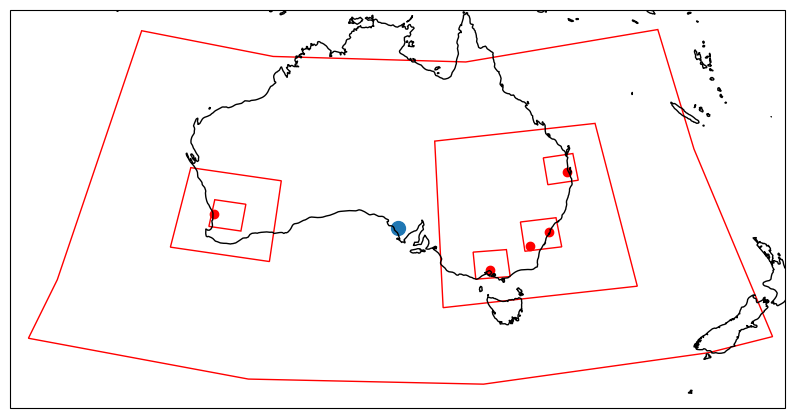

parent_id = 1, 1, 2, 1, 4, 4, 4,
i_parent_start = 1, 34, 34, 126, 34, 123, 87,
j_parent_start = 1, 51, 34, 34, 34, 144, 64,
e_we = 223, 103, 103, 190, 103, 103, 115,
e_sn = 136, 103, 103, 211, 103, 103, 112,
dx = 0.25
dy = 0.25
ref_lat = -33.4
ref_lon = 135.2
pole_lat = 56.6
pole_lon = 0
stand_lon = 44.8


In [6]:
#                                       outer, west, perth, east, melb, bris, cbr-syd,
hf.plot_wrf_domain_def(parent_id      = [    1,    1,     2,    1,    4,    4,      4],
                       i_parent_start = [    1,   34,    34,  126,   34,  123,     87],
                       j_parent_start = [    1,   51,    34,   34,   34,  144,     64],
                       e_we           = [  223,  103,   103,  190,  103,  103,    115],
                       e_sn           = [  136,  103,   103,  211,  103,  103,    112],
                       dx=0.25,
                       dy=0.25,
                       ref_lat=-33.4, 
                       ref_lon=135.2,
                       num_doms=7,
                       scale_factor=3,
                       pts=hf.cities)

Now, after namelist.wps has been updated and geogrid.exe has been run, we can plot the real domains, which should be close to the estimated version above:

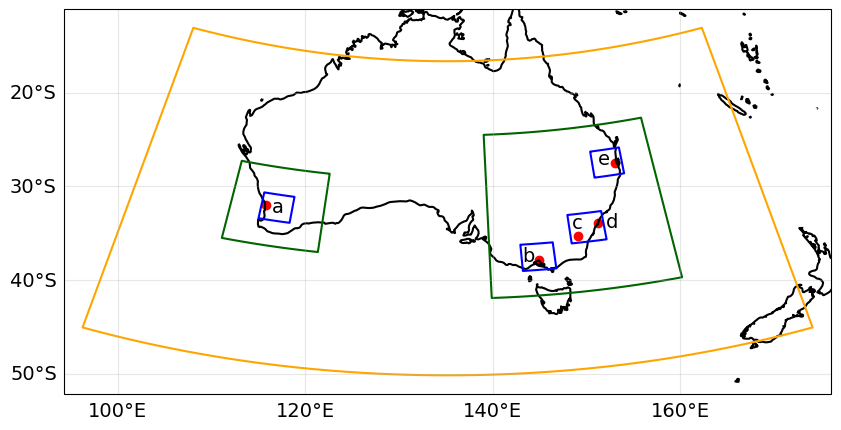

In [ ]:
hf.plot_wrf_domains(wps_dir=f'{base_dir}/WRF_v4.4/simulations/cities/hist/1989-1990/WPS',
                    pts=hf.cities, figsize=(12,5), proj=ccrs.PlateCarree(),
                    labels={'Perth': ('a', (8, -5)),
                            'Melbourne': ('b', (-8, -1)),
                            'Canberra': ('c', (-1, 6)),
                            'Sydney': ('d', (10, -3)),
                            'Brisbane': ('e', (-8, -1))},
                    file='paper/figures/domains.pdf')

### Input data

WRF boundary conditions are supplied from [Xu et al., 2021](https://www.nature.com/articles/s41597-021-01079-3) (data are CC-BY-4.0):

- Publication: https://www.nature.com/articles/s41597-021-01079-3
- Data archive: https://www.scidb.cn/en/detail?dataSetId=791587189614968832

The following code generates scripts that can be run to download all the boundary condition data. Note that the land conditions need to be downloaded and unzipped. The land conditions are in single files available from the data archive link above.

In [8]:
# hf.gen_download_script(years=hist_years, out_file=f'{base_dir}/xu_data/hist/download_hist.sh')
# hf.gen_download_script(years=fut_years, out_file=f'{base_dir}/xu_data/ssp245/download_ssp245_full.sh', fut_ssp='ssp245')

### WRF setup

The following code sets up the directories and WRF files for each run.

In [9]:
#for year in hist_years:
#    hf.set_up_WRF(year=year, template_dir=wrf_template_dir, namelist_dir=namelist_dir, sims_dir=sims_dir+'/hist/', exp='hist')
#for year in fut_years:
#    hf.set_up_WRF(year=year, template_dir=wrf_template_dir, namelist_dir=namelist_dir, sims_dir=sims_dir+'/ssp245/', exp='ssp245')

To run WPS and WRF, e.g. for the historical runs:
    
```
cd /g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/cities/hist
for i in *; do cd $i/WPS/; qsub ~/git/hist_future_hail/scripts/run_WPS.sh; cd ../../; done
for i in *; do cd $i/WRF/; qsub ~/git/hist_future_hail/scripts/run_real.sh; cd ../../; done
for i in *; do cd $i/WRF/; qsub ~/git/hist_future_hail/scripts/run_WRF.sh; cd ../../; done
```

Then to restart WRF, set up the restart runs:

```
for i in */WRF/; do cd $i; echo $i; bash ~/git/hist_future_hail/scripts/restart_WRF.sh; cd ../../; done
```

then run WRF again:

```
for i in *; do cd $i/WRF/; qsub ~/git/hist_future_hail/scripts/run_WRF.sh; cd ../../; done
```

Note that the following temporary files have been removed post-run to save space, but could be generated again using the above scripts:

* `WPS/met_em*.nc`

## WRF settings

By default the runs used a 100 s timestep. Some runs failed due to CFL errors (which with the selected microphysics scheme simply hang at a given timestep). For these runs, I performed a restart and ran that day only with a reduced timestep, then resumed the run with 100 s timesteps afterwards. The days run with a reduced time step were the following:

Historical:
```
1990-01-23 (60 s)
1990-01-24 (80 s)
1991-02-06 (80 s)
1991-11-18 (80 s)
1994-01-01 (80 s)
1994-02-09 (80 s)
1995-02-06 (80 s)
1995-12-18 (80 s)
1995-12-21 (80 s)
1997-02-03 (80 s)
1997-02-06 (80 s)
1997-02-20 (80 s)
1998-01-17 (80 s)
1998-11-07 (80 s)
1998-12-23 (80 s)
1998-12-24 (60 s)
1999-12-24 (80 s)
2001-02-12 (80 s)
2002-01-09 (80 s)
2002-01-27 (80 s)
2002-11-18 (80 s)
2003-01-16 (80 s)
2007-12-31 (80 s)
2008-01-02 (80 s)
```

SSP2-4.5:
```
2080-11-14 (80 s)
2081-02-06 (80 s)
2084-11-23 (80 s)
2085-01-03 (80 s)
2086-01-28 (80 s)
2086-11-10 (80 s)
2087-02-14 (60 s)
2087-02-18 (80 s)
2087-12-25 (80 s)
2088-01-22 (80 s)
2088-01-30 (80 s)
2088-12-30 (80 s)
2089-01-12 (80 s)
2089-01-17 (80 s)
2090-12-04 (60 s)
2091-01-31 (80 s)
2091-02-13 (80 s)
2091-12-18 (80 s)
2092-01-31 (80 s)
2092-02-23 (60 s)
2092-11-03 (80 s)
2092-11-05 (80 s)
2092-11-19 (80 s)
2092-11-20 (60 s)
2094-01-13 (80 s)
2094-01-16 (80 s)
2094-10-25 (80 s)
2095-01-10 (80 s)
2095-01-12 (80 s)
2095-01-16 (80 s)
2095-01-17 (80 s)
2095-01-18 (80 s)
2095-01-24 (80 s)
2095-01-28 (80 s)
2095-12-23 (80 s)
2096-01-20 (60 s)
2096-01-22 (80 s)
2096-10-22 (80 s)
2096-12-19 (80 s)
2096-12-20 (80 s)
2097-02-03 (80 s)
2098-01-16 (80 s)
2099-12-07 (80 s)
2100-01-20 (60 s)
2100-02-07 (80 s)
2100-02-08 (60 s)
2100-02-09 (60 s)
```

## Note

AFWA calculations were enabled while WRF was compiled in `dm+sm` mode, and I have since found out that AFWA's coding is not thread safe so will overwrite values improperly in `dm+sm` mode. I did a trial for one event and found that all other fields were identical when AFWA was turned off, and a forum post to the WRF forum also confirmed that other variables would be unaffected. The WRF output variables possibly affected are:

```
'AFWA_CAPE', 'AFWA_CAPE_MU', 'AFWA_CIN', 'AFWA_CIN_MU', 'AFWA_HAIL', 'AFWA_LIDX', 
'AFWA_LLWS', 'AFWA_MSLP', 'AFWA_PLFC', 'AFWA_PWAT', 'AFWA_TORNADO', 'AFWA_TOTPRECIP', 
'AFWA_ZLFC', 'GRPL_FLX_MAX', 'TCOLI_MAX', 'WSPD10MAX', 'W_UP_MAX', 'W_DN_MAX'
```

These variables are possibly incorrect and should not be used in this work.